In [1]:
import forest_helper as fh
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve,GridSearchCV, StratifiedKFold,StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, f1_score, make_scorer
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn import preprocessing
import inspect
import pandas as pd
import graphviz
import numpy as np
from matplotlib import rcParams, pyplot as plt
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
from scipy import stats

In [2]:
# IMPORT DATA
all_data = pd.read_csv("providence_merged_new.csv")
data = all_data[['speech_act','consistency', 'utterance_type','intonation','syn_level','connective_meaning','annotation','has_negation','modal_bin']]

In [13]:
# NEW Exclusive vs Inclusive Data Wrangling
exin_new = data.loc[(data['annotation'] == 'OR')]
f = lambda x : 'EX' if x == 'XOR' or x == 'NPQ' else 'IN'
exin_new.loc[:,'connective_meaning']= exin_new.loc[:,'connective_meaning'].map(f)
exin_new_features = pd.get_dummies(exin_new[['speech_act','consistency', 'utterance_type','intonation','syn_level']])
exin_new_labels = np.squeeze(exin_new[['connective_meaning']])

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Final Calculations for Paper Figures

## Learning Curve with (XOR and NPQ) vs all else

In [8]:
training_sizes = np.linspace(0.8 * np.shape(exin_new_labels)[0],0.8 * np.shape(exin_new_labels)[0],1,dtype=int)

In [9]:
# Learning Curve Time!
curve_sizes = np.linspace(1,201,200,dtype=int)
exin_new_sizes, exin_new_lax_f1_mean_in, exin_new_lax_f1_std_in = fh.rfc_learning_curve_bin(exin_new_features,exin_new_labels,curve_sizes,0.05,'f1',True,False,False)
exin_new_sizes, exin_new_lax_f1_mean_ex, exin_new_lax_f1_std_ex = fh.rfc_learning_curve_bin(exin_new_features,exin_new_labels,curve_sizes,0.05,'f1',True,True,False)
exin_new_sizes, exin_new_str_f1_mean_in, exin_new_str_f1_std_in = fh.rfc_learning_curve_bin(exin_new_features,exin_new_labels,curve_sizes,0.2,'f1',True,False,False)
exin_new_sizes, exin_new_str_f1_mean_ex, exin_new_str_f1_std_ex = fh.rfc_learning_curve_bin(exin_new_features,exin_new_labels,curve_sizes,0.2,'f1',True,True,False)

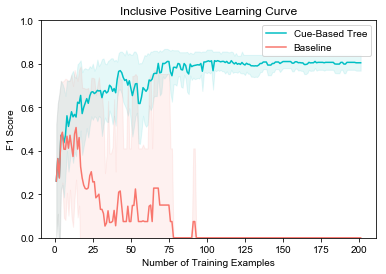

In [12]:
in_plt = [[exin_new_lax_f1_mean_in,exin_new_lax_f1_std_in - exin_new_lax_f1_mean_in],[exin_new_str_f1_mean_in,exin_new_str_f1_std_in - exin_new_str_f1_mean_in]]
fh.plot_learning_curves(exin_new_sizes,in_plt,'Inclusive Positive Learning Curve','F1 Score',['Cue-Based Tree','Baseline'])

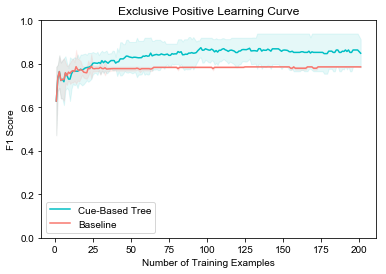

In [13]:
ex_plt = [[exin_new_lax_f1_mean_ex,exin_new_lax_f1_std_ex - exin_new_lax_f1_mean_ex],[exin_new_str_f1_mean_ex,exin_new_str_f1_std_ex - exin_new_str_f1_mean_ex]]
fh.plot_learning_curves(exin_new_sizes,ex_plt,'Exclusive Positive Learning Curve','F1 Score',['Cue-Based Tree','Baseline'])

In [26]:
scores,max_tree_laxer = get_max_estimator(exin_new_features,exin_new_labels,8,0.04)
fh.plot_max_estimator(max_tree_laxer,exin_new_features,sorted(list(exin_new_labels.unique())),'cogsci_plots/exin_0.01')

## XOR VS IOR VS AND

In [16]:
# Exclusive vs Inclusive vs AND Data Wrangling
exinand = data.loc[(data['connective_meaning'] == 'XOR')|(data['connective_meaning'] == 'IOR')|(data['connective_meaning'] == 'AND')]
exinand_features = pd.get_dummies(exinand[['speech_act','consistency', 'utterance_type','intonation','syn_level','annotation','has_negation','modal_bin']])
exinand_labels = np.squeeze(exinand[['connective_meaning']])

In [17]:
curve_sizes = np.linspace(1,201,200,dtype=int)

In [18]:
exinand_sizes, exinand_lax_f1_mean, exinand_lax_f1_std = rfc_learning_curve(exinand_features,exinand_labels,curve_sizes,0.01,'accuracy',True,False,0)
exinand_sizes, exinand_str_f1_mean, exinand_str_f1_std = rfc_learning_curve(exinand_features,exinand_labels,curve_sizes,0.2,'accuracy',True,False,0)

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [19]:
exinand_sizes, exinand_lax_f1_mean_1, exinand_lax_f1_std_1 = rfc_learning_curve(exinand_features,exinand_labels,curve_sizes,0.01,'accuracy',True,False,1)
exinand_sizes, exinand_str_f1_mean_1, exinand_str_f1_std_1 = rfc_learning_curve(exinand_features,exinand_labels,curve_sizes,0.2,'accuracy',True,False,1)

In [21]:
exinand_sizes, exinand_lax_f1_mean_2, exinand_lax_f1_std_2 = rfc_learning_curve(exinand_features,exinand_labels,curve_sizes,0.01,'accuracy',True,False,4)
exinand_sizes, exinand_str_f1_mean_2, exinand_str_f1_std_2 = rfc_learning_curve(exinand_features,exinand_labels,curve_sizes,0.2,'accuracy',True,False,4)

In [5]:
# Calculate Learning Curve over first 10% of data
def rfc_learning_curve(features, labels,training_sizes,gini,score='accuracy',perc=False,return_raw=False,elem=0):
    st = 10
    clf = rfc(n_estimators=20,max_depth=8,max_features=None,min_impurity_decrease=gini,random_state=st)
    ss = StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=st)
    mid = lambda x: x[len(x)/2]
    one = lambda x: x[0] if len(x)==1 else x[1]
    three = lambda x: x[0] if len(x)==1 else x[-2]
    f1 = lambda estimator, X, y : {
        0: f1_score(estimator.predict(X),y,average=None)[0],
        1: one(f1_score(estimator.predict(X),y,average=None)),
        2: mid(f1_score(estimator.predict(X),y,average=None)),
        3: three(f1_score(estimator.predict(X),y,average=None)),
        4: f1_score(estimator.predict(X),y,average=None)[-1]}[elem]
    train_sizes, train_scores, test_scores = learning_curve(
        clf, features, labels, cv=ss, train_sizes=training_sizes,shuffle=True,scoring=f1,random_state=st)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_var  = np.percentile(test_scores,95,axis=1) if perc else np.std(test_scores,axis=1)
    if return_raw:
        return train_sizes,test_scores 
    else:
        return train_sizes,test_scores_mean, test_scores_var

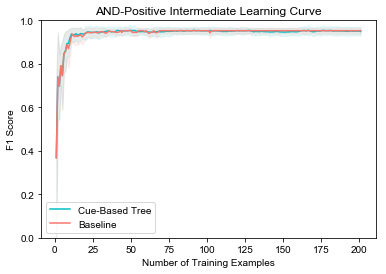

In [28]:
exinand_plt = [[exinand_lax_f1_mean,exinand_lax_f1_std - exinand_lax_f1_mean],[exinand_str_f1_mean,exinand_str_f1_std - exinand_str_f1_mean]]
plot_learning_curves(exinand_sizes,exinand_plt,'AND-Positive Intermediate Learning Curve','F1 Score',['Cue-Based Tree','Baseline',])

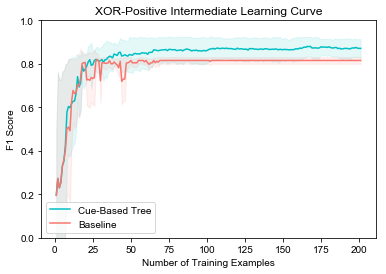

In [30]:
exinand_plt_2 = [[exinand_lax_f1_mean_2,exinand_lax_f1_std_2 - exinand_lax_f1_mean_2],[exinand_str_f1_mean_2,exinand_str_f1_std_2 - exinand_str_f1_mean_2]]
plot_learning_curves(exinand_sizes,exinand_plt_2,'XOR-Positive Intermediate Learning Curve','F1 Score',['Cue-Based Tree','Baseline',])

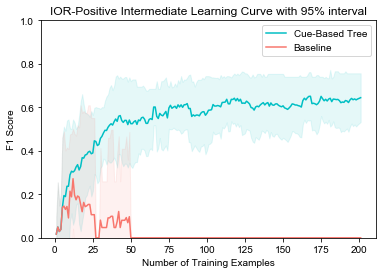

In [32]:
exinand_plt_1 = [[exinand_lax_f1_mean_1,exinand_lax_f1_std_1 - exinand_lax_f1_mean_1],[exinand_str_f1_mean_1,exinand_str_f1_std_1 - exinand_str_f1_mean_1]]
plot_learning_curves(exinand_sizes,exinand_plt_1,'IOR-Positive Intermediate Learning Curve with 95% interval','F1 Score',['Cue-Based Tree','Baseline',])

In [47]:
scores,max_tree_laxer = get_max_estimator(exinand_features,exinand_labels,8,0.01)
fh.plot_max_estimator(max_tree_laxer,exinand_features,sorted(list(exinand_labels.unique())),'cogsci_plots/exinand_0.01')

In [48]:
scores,max_tree_str = get_max_estimator(exinand_features,exinand_labels,8,0.2)
fh.plot_max_estimator(max_tree_str,exinand_features,sorted(list(exinand_labels.unique())),'cogsci_plots/exinand_0.2')

## ALL CATEGORIES

In [33]:
# Exclusive vs Inclusive vs AND Data Wrangling
whole = data.loc[((data['connective_meaning'] != 'XNOR') & (data['connective_meaning'] != 'NAND'))]
#whole = data.loc[(data['connective_meaning'] != 'XNOR')]
whole_features = pd.get_dummies(whole[['speech_act','consistency', 'utterance_type','intonation','syn_level','annotation','has_negation','modal_bin']])
whole_labels = np.squeeze(whole[['connective_meaning']])

In [34]:
curve_sizes = np.linspace(1,201,200,dtype=int)

In [35]:
# Learning Curve Time!
whole_sizes, whole_lax_f1_mean, whole_lax_f1_std = rfc_learning_curve(whole_features,whole_labels,curve_sizes,0.01,'accuracy',True,False,0)
whole_sizes, whole_str_f1_mean, whole_str_f1_std = rfc_learning_curve(whole_features,whole_labels,curve_sizes,0.2,'accuracy',True,False,0)

In [36]:
whole_sizes, whole_lax_f1_mean_1, whole_lax_f1_std_1 = rfc_learning_curve(whole_features,whole_labels,curve_sizes,0.01,'accuracy',True,False,1)
whole_sizes, whole_str_f1_mean_1, whole_str_f1_std_1 = rfc_learning_curve(whole_features,whole_labels,curve_sizes,0.2,'accuracy',True,False,1)

In [37]:
whole_sizes, whole_lax_f1_mean_2, whole_lax_f1_std_2 = rfc_learning_curve(whole_features,whole_labels,curve_sizes,0.01,'accuracy',True,False,2)
whole_sizes, whole_str_f1_mean_2, whole_str_f1_std_2 = rfc_learning_curve(whole_features,whole_labels,curve_sizes,0.2,'accuracy',True,False,2)

In [38]:
whole_sizes, whole_lax_f1_mean_3, whole_lax_f1_std_3 = rfc_learning_curve(whole_features,whole_labels,curve_sizes,0.01,'accuracy',True,False,3)
whole_sizes, whole_str_f1_mean_3, whole_str_f1_std_3 = rfc_learning_curve(whole_features,whole_labels,curve_sizes,0.2,'accuracy',True,False,3)

In [39]:
whole_sizes, whole_lax_f1_mean_4, whole_lax_f1_std_4 = rfc_learning_curve(whole_features,whole_labels,curve_sizes,0.01,'accuracy',True,False,4)
whole_sizes, whole_str_f1_mean_4, whole_str_f1_std_4 = rfc_learning_curve(whole_features,whole_labels,curve_sizes,0.2,'accuracy',True,False,4)

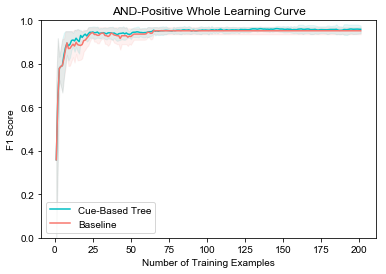

In [41]:
whole_plt = [[whole_lax_f1_mean,whole_lax_f1_std - whole_lax_f1_mean],[whole_str_f1_mean,whole_str_f1_std - whole_str_f1_mean]]
plot_learning_curves(whole_sizes,whole_plt,'AND-Positive Whole Learning Curve','F1 Score',['Cue-Based Tree','Baseline',])

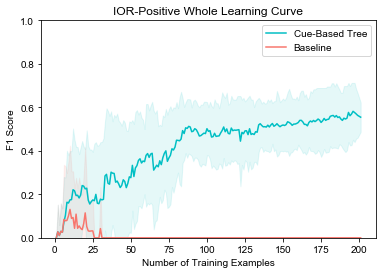

In [45]:
whole_plt_1 = [[whole_lax_f1_mean_1,whole_lax_f1_std_1 - whole_lax_f1_mean_1],[whole_str_f1_mean_1,whole_str_f1_std_1 - whole_str_f1_mean_1]]
plot_learning_curves(whole_sizes,whole_plt_1,'IOR-Positive Whole Learning Curve','F1 Score',['Cue-Based Tree','Baseline',])

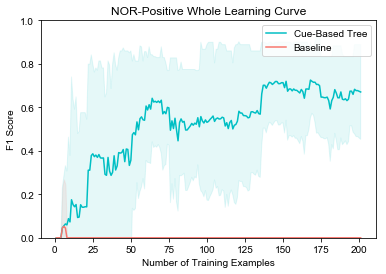

In [43]:
whole_plt_2 = [[whole_lax_f1_mean_2,whole_lax_f1_std_2 - whole_lax_f1_mean_2],[whole_str_f1_mean_2,whole_str_f1_std_2 - whole_str_f1_mean_2]]
plot_learning_curves(whole_sizes,whole_plt_2,'NOR-Positive Whole Learning Curve','F1 Score',['Cue-Based Tree','Baseline',])

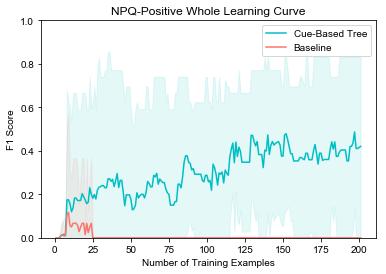

In [46]:
whole_plt_3 = [[whole_lax_f1_mean_3,whole_lax_f1_std_3 - whole_lax_f1_mean_3],[whole_str_f1_mean_3,whole_str_f1_std_3 - whole_str_f1_mean_3]]
plot_learning_curves(whole_sizes,whole_plt_3,'NPQ-Positive Whole Learning Curve','F1 Score',['Cue-Based Tree','Baseline',])

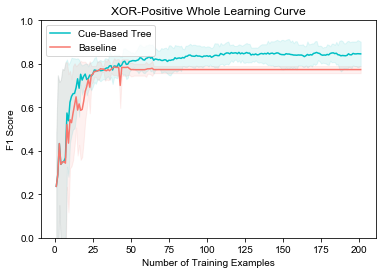

In [49]:
whole_plt_4 = [[whole_lax_f1_mean_4,whole_lax_f1_std_4 - whole_lax_f1_mean_4],[whole_str_f1_mean_4,whole_str_f1_std_4 - whole_str_f1_mean_4]]
plot_learning_curves(whole_sizes,whole_plt_4,'XOR-Positive Whole Learning Curve','F1 Score',['Cue-Based Tree','Baseline',])

In [49]:
scores,max_tree_lax = get_max_estimator(whole_features,whole_labels,8,0.01)
fh.plot_max_estimator(max_tree_lax,whole_features,sorted(list(whole_labels.unique())),'cogsci_plots/whole_0.01')

In [23]:
sorted(list(whole_labels.unique()))

['AND', 'IOR', 'NOR', 'NPQ', 'XOR']

In [50]:
scores,max_tree_str = get_max_estimator(whole_features,whole_labels,8,0.2)
fh.plot_max_estimator(max_tree_str,whole_features,sorted(list(whole_labels.unique())),'cogsci_plots/whole_0.2')

In [17]:
# Helper Function
def get_max_estimator(features,labels,depth,mind):
    st = 10
    #ss = StratifiedKFold(n_splits=10,random_state=st)
    ss = StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=st)
    clf = rfc(n_estimators=10,max_depth=depth,max_features=None,min_impurity_decrease=mind,random_state=st)
    max_tree = 0
    for train, test in ss.split(features,labels):
        x_train, x_test, y_train, y_test = features.iloc[train], features.iloc[test],labels.iloc[train],labels.iloc[test]
        clf.fit(x_train,y_train)
        for estimator in clf.estimators_:
            if max_tree is 0 or estimator.score(x_test,y_test) > max_tree.score(x_test,y_test):
                max_tree = estimator
    scores = cross_val_score(clf, features, labels, cv=ss)
    return scores, max_tree

In [3]:
# Plot Learning Curve
def plot_learning_curves(train_sizes, mean_std_array,title, xlabel,labels):
    colors = ['#00BFC4','#F8766D']
    i = 0
    for mean_std in mean_std_array:
        mean = mean_std[0]
        std = mean_std[1]
        plt.fill_between(train_sizes, mean - std, mean + std, alpha=0.1,color=colors[i%2])
        plt.plot(train_sizes, mean,color=colors[i%2],label=labels[i])
        i+=1
    plt.xlabel('Number of Training Examples')
    plt.ylabel(xlabel)
    plt.title(title)
    plt.legend()
    axes = plt.gca()
    axes.set_ylim([0,1])
    plt.show()

## XOR IOR AND for only OR annotations

In [6]:
# Exclusive vs Inclusive vs AND Data Wrangling
ornew = data.loc[(data['annotation'] == 'OR')]
xoriorand = ornew.loc[(ornew['connective_meaning'] == 'XOR')|(ornew['connective_meaning'] == 'IOR')|(ornew['connective_meaning'] == 'AND')]
xoriorand_features = pd.get_dummies(xoriorand[['speech_act','consistency', 'utterance_type','intonation','syn_level','annotation','has_negation','modal_bin']])
xoriorand_labels = np.squeeze(xoriorand[['connective_meaning']])

In [7]:
curve_sizes = np.linspace(1,201,200,dtype=int)

In [8]:
xoriorand_sizes, xoriorand_lax_f1_mean, xoriorand_lax_f1_std = rfc_learning_curve(xoriorand_features,xoriorand_labels,curve_sizes,0.01,'accuracy',True,False,0)
xoriorand_sizes, xoriorand_str_f1_mean, xoriorand_str_f1_std = rfc_learning_curve(xoriorand_features,xoriorand_labels,curve_sizes,0.2,'accuracy',True,False,0)

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [9]:
xoriorand_sizes, xoriorand_lax_f1_mean_1, xoriorand_lax_f1_std_1 = rfc_learning_curve(xoriorand_features,xoriorand_labels,curve_sizes,0.01,'accuracy',True,False,1)
xoriorand_sizes, xoriorand_str_f1_mean_1, xoriorand_str_f1_std_1 = rfc_learning_curve(xoriorand_features,xoriorand_labels,curve_sizes,0.2,'accuracy',True,False,1)

In [10]:
xoriorand_sizes, xoriorand_lax_f1_mean_2, xoriorand_lax_f1_std_2 = rfc_learning_curve(xoriorand_features,xoriorand_labels,curve_sizes,0.01,'accuracy',True,False,4)
xoriorand_sizes, xoriorand_str_f1_mean_2, xoriorand_str_f1_std_2 = rfc_learning_curve(xoriorand_features,xoriorand_labels,curve_sizes,0.2,'accuracy',True,False,4)

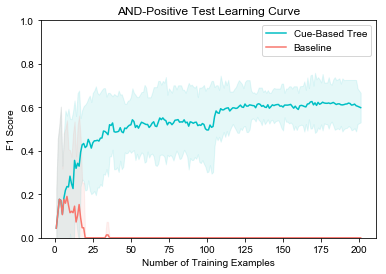

In [14]:
xoriorand_plt = [[xoriorand_lax_f1_mean,xoriorand_lax_f1_std - xoriorand_lax_f1_mean],[xoriorand_str_f1_mean,xoriorand_str_f1_std - xoriorand_str_f1_mean]]
plot_learning_curves(xoriorand_sizes,xoriorand_plt,'AND-Positive Test Learning Curve','F1 Score',['Cue-Based Tree','Baseline',])

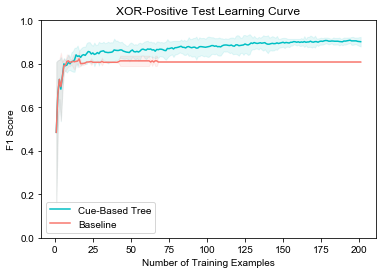

In [15]:
xoriorand_plt_2 = [[xoriorand_lax_f1_mean_2,xoriorand_lax_f1_std_2 - xoriorand_lax_f1_mean_2],[xoriorand_str_f1_mean_2,xoriorand_str_f1_std_2 - xoriorand_str_f1_mean_2]]
plot_learning_curves(xoriorand_sizes,xoriorand_plt_2,'XOR-Positive Test Learning Curve','F1 Score',['Cue-Based Tree','Baseline',])

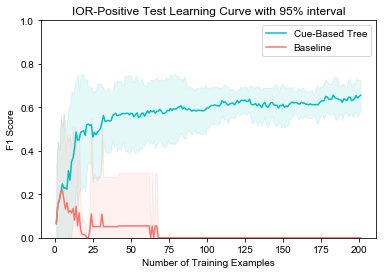

In [16]:
xoriorand_plt_1 = [[xoriorand_lax_f1_mean_1,xoriorand_lax_f1_std_1 - xoriorand_lax_f1_mean_1],[xoriorand_str_f1_mean_1,xoriorand_str_f1_std_1 - xoriorand_str_f1_mean_1]]
plot_learning_curves(xoriorand_sizes,xoriorand_plt_1,'IOR-Positive Test Learning Curve with 95% interval','F1 Score',['Cue-Based Tree','Baseline',])

In [18]:
scores,max_tree_lax = get_max_estimator(xoriorand_features,xoriorand_labels,8,0.01)
fh.plot_max_estimator(max_tree_lax,xoriorand_features,sorted(list(xoriorand_labels.unique())),'cogsci_plots/test_0.01')

In [19]:
scores,max_tree_str = get_max_estimator(xoriorand_features,xoriorand_labels,8,0.2)
fh.plot_max_estimator(max_tree_str,xoriorand_features,sorted(list(xoriorand_labels.unique())),'cogsci_plots/xoriorand_0.2')